In [1]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time



#I/O 

now_path            =   '../BRILLOUIN/TDP43/ARS_13_02/'
spectra_filename    =   'ARS_13_02'
VIPA_filename       =   'ARS_13_02_VIPA_quasisat.tif'
log_file            =   'log_'+spectra_filename
analysis_dir       =   'analysis_best/'

#operatives

#esclusi a mano
to_add              =   [(66, 3),]

syg_kwargs          =   {'height': 80, 'distance': 31, 'width': 3.}
syg_kwargs_VIPA     =   {'distance':70, 'width': 1}
syg_kwargs_brill    =  {'height': 18, 'distance': 31, 'width': 3.}
VIPA_treshold       =   6
sat_height          =   50000
sat_width           =   13.5
almost_treshold     =   15000

#quanto mi allontano dal VIPA
pre_cut             =   False
cut                 =   True

mean_dist_01 = 37
mean_dist_23 = 35

#markov_fit
p0_normal = np.array([ 1.07378474e-01,  7.57148558e+00,  1.49128813e-01,  1.19015861e-01,
        1.448930518e-01,  8.34614271,  4.79747192e+03, -1.00904973e+01,
        1.58007162e+01,  2.11019859e-01, -3.10388495e-01])
p0_brillouin = np.array([ 1.07378474e-01,  7.57148558e+00,  1.49128813e-01,  1.19015861e-01,
        1.48930518e-01,  2.34614271e-01,  4.79747192e+03, -1.00904973e+01,
        1.58007162e+01,  2.11019859e-01, -3.10388495e-01])
p0_almost = np.array([ 1.07186924e-01,  7.63051819e+00,  1.33280055e-01,  1.97510814e+00,
        5.09986043e-01,  1.66616101e+00,  4.33362727e+03, -1.00496864e+01,
        1.59365161e+01,  2.77695117e-01,  6.43211621e+00])

recover_markov = False
rules_markov_bounds     =   ('positive', 0.2, 'positive', [-2,2] , 'positive', 'positive', 0.2, 0.01, 0.001,  'inf', [-2,2])
#tot fit
skip_tot = False
rules_tot_bounds                   =   (0.2, 0.01, 0.01, 'positive', 'positive', [-2,2], 0.01, 0.01, 'inf', 0.5)

############


cols_basic  = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude')
cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position',  'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_position', 'delta_width',  'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark_nodelta  = ('Co', 'Omega', 'Gamma', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')

ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat


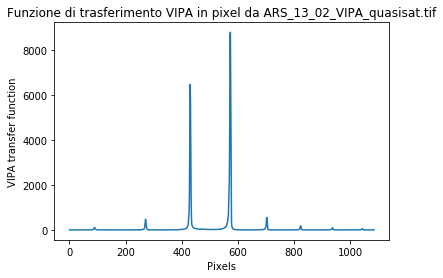

Text(0.5, 1.0, '(12, 35)')

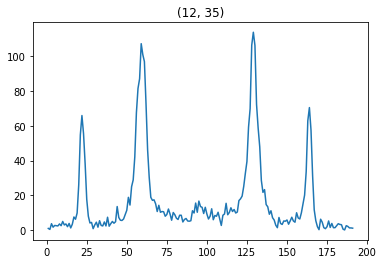

In [2]:
#0) importo dati e inizializzo oggetti
i   =   12
j   =   35
y    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y3')[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = pre_cut, cut_range = (10, 175))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = 'VIPA_img', save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.title(str((i,j)))

Lo spettro è brillouin_highest_dx
Lo spettro ha 4 picchi


Text(0.5, 1.0, '(12, 35)')

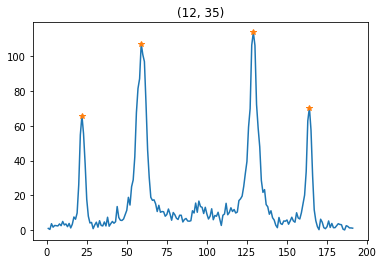

In [3]:
#1) Classificazione e visualizzazione spettro
check = Data.Check_Spectrum_Saturation(saturation_height = sat_height, saturation_width = sat_width)

if      check == 1  : nature    = 'saturo'
elif    (Data.n_peaks == 2) :

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    if (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][1]]) & (Data.y[Data.peaks['idx'][2]] > Data.y[Data.peaks['idx'][3]]):
        nature    = 'brillouin_highest_dx'
    elif (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][2]]) & (Data.y[Data.peaks['idx'][1]] > Data.y[Data.peaks['idx'][0]]):
        nature    = 'brillouin_highest_sx'
    else:
        raise ValueError ('Non ho riconosciuto lo spettro\n')

elif (Data.n_peaks == 3) :
    Data.Get_Spectrum_Peaks(**syg_kwargs_brill) 
    nature = 'brillouin_higher'

elif Data.y.max() > almost_treshold:
    nature = 'almost_height'
else:                 nature    = 'normal'
print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))
plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks['idx']], Data.y[Data.peaks['idx']], '*')
plt.title(str((i,j)))

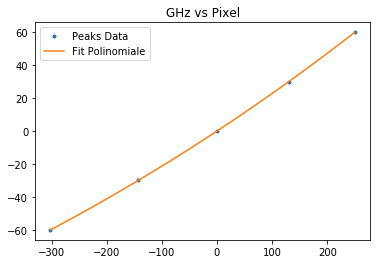

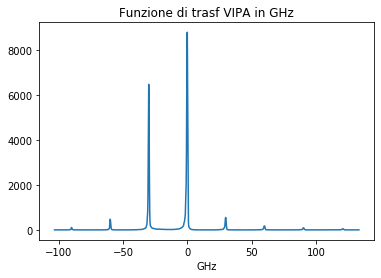

In [4]:
#2) Operazioni di conversione in GHz

Data.How_Many_Peaks_To_VIPA(treshold = VIPA_treshold, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)


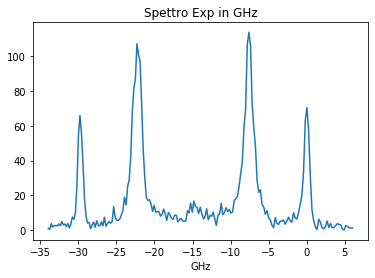

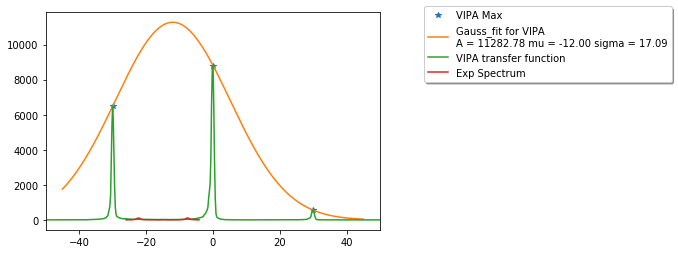

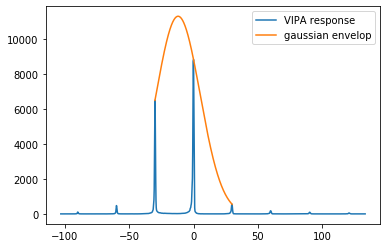

In [5]:
#3) Eseeguo taglio e stima parametri iniziali spettro, verifichepositive
from Alessandria import gaussian
Data.Align_Spectrum()
Data.Spectrum_Pix2GHz(fig = True)
Data.Cut_n_Estimate_Spectrum(estimate = True, cut = cut, mean_dist01 = mean_dist_01, mean_dist23 = mean_dist_23, verbose = True)
Data.Fit_VIPA_Gaussian(fig = True)
plt.figure()
plot(Data.x_VIPA_freq, Data.y_VIPA, label = 'VIPA response')
x = np.linspace(-30,30,1000)
plt.plot(x, gaussian(x, *Data.p0[list(cols_gauss)].values[0]), label = 'gaussian envelop')
plt.legend()

Cost before fitting = 920265.7494178306
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.2027e+05                                    1.83e+06    
       1              2         2.3132e+05      6.89e+05       9.17e+02       1.25e+06    
       2              3         6.0531e+04      1.71e+05       1.87e+01       5.39e+05    
       3              4         1.4727e+04      4.58e+04       1.89e+03       8.09e+04    
       4              5         3.5424e+03      1.12e+04       7.87e+01       2.45e+04    
       5              6         9.4681e+02      2.60e+03       1.82e+03       8.89e+03    
       6              7         3.6417e+02      5.83e+02       2.06e+03       4.54e+03    
       7              8         1.7898e+02      1.85e+02       1.63e+03       4.75e+03    
       8              9         1.0265e+02      7.63e+01       7.97e+02       3.22e+01    
       9             10         8.5887e+01      1.

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.004962,7.582260,0.170105,0.248154,0.000014,0.336255,1.353929e+04,-11.884167,17.073180,0.144095,2.000000
StdErrs,0.006966,0.023183,0.015672,0.000666,0.229442,5691.000519,2.373649e+10,16.406336,41.409922,0.021689,0.660764
Initials,0.010000,7.349645,0.100000,0.000000,0.100000,1.000000,1.128278e+04,-12.004209,17.090271,0.000000,0.000000


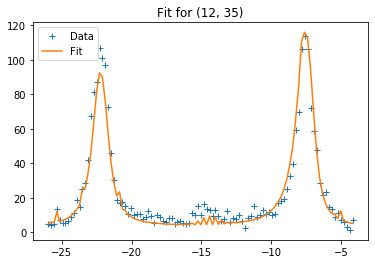

In [10]:
#3) fit markoviano

if (nature != 'brillouin_higher') & (nature != 'brillouin_highest'):

    columns = cols_mark
    Data.Get_Fit_Bounds(rules_markov_bounds, columns)

else:
    columns = cols_mark_nodelta
    Data.Get_Fit_Bounds(rules_markov_bounds[0:3]+rules_markov_bounds[6:], columns)

columns = cols_mark
Data.Get_Fit_Bounds(rules_markov_bounds, columns)

Data.Get_VIPA_for_fit(mode = 'interpolate', interpolation_density = 500)

p0s = [Data.p0[list(columns)].values[0]]#, p0_almost, p0_brillouin, p0_normal]
Data.Get_Best_p0(p0s, columns)
Data.Get_cost_markov(Data.p0[list(columns)].values[0], columns = columns)
print('Cost before fitting = {}'.format(Data.cost_markov))

_= Data.Non_Linear_Least_Squares_Markov(columns, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, max_nfev = 200, fig = True, zoom = False)
#_ = Data.Non_Linear_Least_Squares_Markov(bound = (Data.bounds['down'].values, Data.bounds['up'].values),  max_nfev = 500)
Data.Get_cost_markov(Data.Markov_Fit_Params.values[0], columns = columns)
print('Cost after fitting = {}\n'.format(Data.cost_markov))
Data.Markov_Fit_Params

In [11]:
Data.Markov_Fit_Params.values[0]

array([ 4.96244266e-03,  7.58226042e+00,  1.70105238e-01,  2.48154304e-01,
        1.35562646e-05,  3.36255314e-01,  1.35392869e+04, -1.18841667e+01,
        1.70731804e+01,  1.44094621e-01,  2.00000000e+00])

In [8]:
Data.Markov_Fit_Params

AttributeError: 'Spectrum' object has no attribute 'Markov_Fit_Params'

In [9]:
_ = Data.Gauss_Convolve_Markovian_Response(Data.Markov_Fit_Params.values[0], fantoccio = (-50, 50), fig = True, compare = True)
plt.ylim(-10, 250)

AttributeError: 'Spectrum' object has no attribute 'Markov_Fit_Params'

In [10]:
#4) fit totale
rules_tot_bounds                    =   (0.2, 0.01, 0.01, 'positive', 'positive', 0.01, 0.01, 0.01, 'inf', 0.5)
print(Data.p0[list(cols_mark)])
Data.Initials_Parameters_from_Markov(Data.Markov_Fit_Params, cols_mark)
print(Data.p0[list(cols_mark)])
Data.Get_Fit_Bounds(rules_tot_bounds, columns = cols_real)
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]
#Data.Get_p0(Data.p0[list(cols_real)].values[0], cols_real)
Data.Non_Linear_Least_Squares(p_gauss, cols_real, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 50)
Data.Tot_Fit_Params

Co     Omega  Gamma  delta_position  delta_width  delta_amplitude  \
Values  0.01  7.559659    0.1             0.0          0.1                1   

                   A         mu      sigma  shift  offset  
Values  11282.784125 -12.004209  17.090271    0.0       0  


AttributeError: 'Spectrum' object has no attribute 'Markov_Fit_Params'

In [11]:
p0 = np.array([1.21281641e-02, 7.72206371e+00, 1.94690324e-01, 0,
       0,1.35547082e+00, 5.10605549e-01, 8.38919312e-01,
       1.82962060e-02, 1.00000000e+00])
kernel                  =       Data.VIPA_w_j/(p_gauss[0]*(np.exp(-((Data.w_j_VIPA-p_gauss[1])**2)/(2*(p_gauss[2]**2)))))
_ = Data.Convolve_Theoretical_Response(Data.p0, p_gauss, kernel, fig = True, fantoccio = (-50, 50))
plt.plot(Data.x_freq, Data.y, '+', label = 'data')
plt.plot(Data.x_freq, Data.y_markov_fit, '--', label = 'markov')
plt.plot(Data.x_freq, Data.y_fit, '-.', label = 'tot')
plt.legend()
plt.xlim(-35, 10)
plt.ylim(-10, 400)

AttributeError: 'Spectrum' object has no attribute 'VIPA_w_j'

In [12]:
_ = S_2_Generate(*Data.Tot_Fit_Params.values[0][0:8], -15, 15, 200, fig = True )

AttributeError: 'Spectrum' object has no attribute 'Tot_Fit_Params'

In [13]:
cols_real

('Co',
 'Omega',
 'Gamma',
 'Delta',
 'tau',
 'delta_position',
 'delta_width',
 'delta_amplitude',
 'shift',
 'offset')

In [14]:
from Models import S_Dynamical_Form_Factor_2_nodelta
def S_2_Generate(Co, Omega, Gamma, Delta, tau, delta_position, delta_width, delta_amplitude, x_min, x_max, density, fig = False):

    x   =   np.linspace(x_min,x_max,  density)
    y   =   lorentian(x, delta_position, delta_width, delta_amplitude) + S_Dynamical_Form_Factor_2_nodelta(x, Co, Omega, Gamma, Delta, tau)

    
    if fig:
        
        plt.figure()
        plt.title('S_2 generated data')
        plt.plot(x,y,'.')


    return (x,y)

In [15]:
p0  = Data.p0
Markov_Fit_Params = Data.Markov_Fit_Params
p0

AttributeError: 'Spectrum' object has no attribute 'Markov_Fit_Params'

In [16]:
p0[list(cols_mark)].update(Markov_Fit_Params)
p0

NameError: name 'Markov_Fit_Params' is not defined

In [17]:
p0

,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.01,7.559659,0.1,0.1,1.0,0.0,0.1,1,11282.784125,-12.004209,17.090271,0.0,0
